# 残差网络（ResNet）
:label:`sec_resnet`

随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力，
为了取得质的突破，我们需要一些数学基础知识。

## 函数类

首先，假设有一类特定的神经网络架构$\mathcal{F}$，它包括学习速率和其他超参数设置。
对于所有$f \in \mathcal{F}$，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得。
现在假设$f^*$是我们真正想要找到的函数，如果是$f^* \in \mathcal{F}$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。
相反，我们将尝试找到一个函数$f^*_\mathcal{F}$，这是我们在$\mathcal{F}$中的最佳选择。
例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，我们可以尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

那么，怎样得到更近似真正$f^*$的函数呢？
唯一合理的可能性是，我们需要设计一个更强大的架构$\mathcal{F}'$。
换句话说，我们预计$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更近似”。
然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，则无法保证新的体系“更近似”。
事实上，$f^*_{\mathcal{F}'}$可能更糟：
如 :numref:`fig_functionclasses`所示，对于非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^*$靠拢（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）。
在 :numref:`fig_functionclasses`的左边，虽然$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，但$\mathcal{F}_6$却离的更远了。
相反对于 :numref:`fig_functionclasses`右侧的嵌套函数（nested function）类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，我们可以避免上述问题。

![对于非嵌套函数类，较复杂（由较大区域表示）的函数类不能保证更接近“真”函数（ $f^*$ ）。这种现象在嵌套函数类中不会发生。](../img/functionclasses.svg)
:label:`fig_functionclasses`

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。
对于深度神经网络，如果我们能将新添加的层训练成*恒等映射*（identity function）$f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。
同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

针对这一问题，何恺明等人提出了*残差网络*（ResNet） :cite:`He.Zhang.Ren.ea.2016`。
它在2015年的ImageNet图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。
残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。
于是，*残差块*（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。
凭借它，ResNet赢得了2015年ImageNet大规模视觉识别挑战赛。

## (**残差块**)

让我们聚焦于神经网络局部：如图 :numref:`fig_residual_block`所示，假设我们的原始输入为$x$，而希望学出的理想映射为$f(\mathbf{x})$（作为 :numref:`fig_residual_block`上方激活函数的输入）。
 :numref:`fig_residual_block`左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$，而右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x}) - \mathbf{x}$。
残差映射在现实中往往更容易优化。
以本节开头提到的恒等映射作为我们希望学出的理想映射$f(\mathbf{x})$，我们只需将 :numref:`fig_residual_block`中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(\mathbf{x})$即为恒等映射。
实际中，当理想映射$f(\mathbf{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。
 :numref:`fig_residual_block`右图是ResNet的基础架构--*残差块*（residual block）。
在残差块中，输入可通过跨层数据线路更快地向前传播。

![一个正常块（左图）和一个残差块（右图）。](../img/residual-block.svg)
:label:`fig_residual_block`

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。
残差块的实现如下：


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

如 :numref:`fig_resnet_block`所示，此代码生成两种类型的网络：
一种是当`use_1x1conv=False`时，应用ReLU非线性函数之前，将输入添加到输出。
另一种是当`use_1x1conv=True`时，添加通过$1 \times 1$卷积调整通道和分辨率。

![包含以及不包含 $1 \times 1$ 卷积层的残差块。](../img/resnet-block.svg)
:label:`fig_resnet_block`

下面我们来查看[**输入和输出形状一致**]的情况。


In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在[**增加输出通道数的同时，减半输出的高和宽**]。


In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet模型**]

ResNet的前两层跟之前介绍的GoogLeNet中的一样：
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
不同之处在于ResNet每个卷积层后增加了批量规范化层。


In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。
ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。
第一个模块的通道数同输入通道数一致。
由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。


In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。


In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。


In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的$1\times 1$卷积层）。
加上第一个$7\times 7$卷积层和最后一个全连接层，共有18层。
因此，这种模型通常被称为ResNet-18。
通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。
虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。
 :numref:`fig_resnet18`描述了完整的ResNet-18。

![ResNet-18 架构](../img/resnet18.svg)
:label:`fig_resnet18`

在训练ResNet之前，让我们[**观察一下ResNet中不同模块的输入形状是如何变化的**]。
在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。


In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

同之前一样，我们在Fashion-MNIST数据集上训练ResNet。


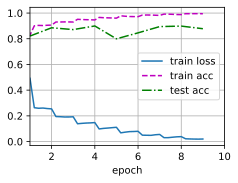

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
* 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
* 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
* 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。

## 练习

1.  :numref:`fig_inception`中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？
1. 参考ResNet论文 :cite:`He.Zhang.Ren.ea.2016`中的表1，以实现不同的变体。
1. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。
1. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见 :cite:`He.Zhang.Ren.ea.2016*1`中的图1。
1. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？


[Discussions](https://discuss.d2l.ai/t/1877)


# **ResNet50 / 34的网络架构**
#### 假设输入图像的尺寸为 (3, 224, 224)

In [6]:
import torch
import torchvision.models as models

# 加载预训练的ResNet50模型
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### **〇  Stem层**
```python
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  
  (relu): ReLU(inplace=True)  
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)  
```
#### 0. **总体作用：**
1. **空间尺寸缩小**：分辨率缩小，减少后续层的计算量。
2. **特征提取**：Stem层使用较大的卷积核（7×7），可从较大局部区域中提取低级特征（例如边缘、纹理等），为后续的卷积层提供有意义的初始特征。
3. **归一化与激活**：通过批量归一化和ReLU激活函数，网络变得更加稳定，并且可以引入非线性特征。
   
#### 1. **Conv2d (conv1)**
   - `Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)`
   - 这是第一个卷积层，它的作用是对输入图像进行卷积操作。具体解释如下：  
     - **输入通道数**为3，表示RGB彩色图像的3个通道。
     - **输出通道数**为64，表示这个卷积层会**将输入图像映射到64个特征通道。**
     - **卷积核大小**为7×7，意味着在图像的局部区域中寻找特征。
     - **步长**为2，这意味着输出的空间分辨率会被缩小一半。
     - **填充**为3，这确保了卷积操作后图像的空间尺寸不会缩小太多。
     - **Conv2d** 中的 2d 代表了二维卷积，即在图像的二维空间上进行的卷积操作。
     - **conv1** 是这一层的名称，通常代表网络中的第一个卷积层。    
  
$$H_{out} = \left\lfloor \frac{H_{in} + 2P - K}{S} \right\rfloor + 1$$
- **卷积层的输出尺寸公式**，其中：
$$
\begin{aligned} 
& H_{out} : \text{ 输出的高度或宽度（空间维度）} \\
& H_{in}  : \text{ 输入的高度或宽度（空间维度）} \\
& P       : \text{ 填充（padding）的大小} \\
& K       : \text{ 卷积核（kernel）的大小} \\
& S       : \text{ 步长（stride）} \\
& \left\lfloor x \right\rfloor : \text{ 向下取整}
\end{aligned}
$$

#### 2. **BatchNorm2d (bn1)**
   - `BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)`
   - 这是一个批量归一化层，它用于规范化卷积层的输出，减少内部**协变量偏移**。它有助于**加快收敛速度**，**防止过拟合**。

#### 3. **ReLU (relu)**
   - `ReLU(inplace=True)`
   - 这是一个激活函数，采用了ReLU（Rectified Linear Unit）作为非线性激活函数，主要作用是**引入非线性**，使得网络可以**学习到更复杂的特征**。

#### 4. **MaxPool2d (maxpool)**
   - `MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)`
   - 这是一个最大池化层，进一步降低特征图的空间分辨率，同时保留重要的特征。对输入的特征进行下采样，减少后续计算量，并提取重要的局部特征。
     - **池化窗口大小**为3×3，意味着在3x3的局部区域内取最大值。
     - **步长**为2，意味着空间分辨率再次缩小一半。



  

### **①Layer1**
```python
  (layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck()
    (2): Bottleneck()
    (3): Bottleneck()
  )
```

### **区别**：only第一个 **Bottleneck** 模块包含 **downsample** 过程

#### 1. **相同的 Bottleneck**
- **`layer1`** 是一个 `Sequential` 模块，包含 3 个 `Bottleneck` 模块。
- **conv1**: `Conv2d(64, 64)`，输入通道是 64，输出通道也是 64。
- **conv2**: `Conv2d(64, 64)`，保持通道不变。
- **conv3**: `Conv2d(64, 256)`，通过 1x1 卷积将通道扩展到 256。

#### 2. **独有的 downsample**
 - 这是一个额外的分支，用于调整输入的通道数，以确保跳跃连接时，输入和输出通道一致。
 - `Conv2d(64, 256)` 将输入通道从 64 调整到 256。
 - **BatchNorm** 进行规范化。

#### 3. **为什么？**

- 第一个残差块（这里的第一个 **Bottleneck**）通常会调整输入的通道数，因为在层次传递过程中，网络需要**扩大特征通道数以捕捉更多复杂的特征。**  
- so需要通过 downsample 对输入特征进行变换（包括通道数的变化），以确保残差连接时输入和输出的**维度一致。**  
- 而后续的 Bottleneck 模块则不需要再调整，因为输入和输出的通道数**已经对齐。**  

### **Table 1: ResNet 网络架构**
<!-- 
![ResNet 网络架构](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rAXVJiNPgsoDwU3ULneb7A.png)
:label:`Table 1`
 -->
<div style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rAXVJiNPgsoDwU3ULneb7A.png" alt="ResNet 网络架构" width="800"/>
    <p><strong>Table 1: ResNet 网络架构</strong></p>
</div>



### **Layer2**
```python
(layer2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(256/512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(512)
    (2): Bottleneck(512)
    (3): Bottleneck(512)
  )
```

### **整体结构：**
- **`layer2`** 是一个 `Sequential` 模块，包含 4 个 `Bottleneck` 模块。
- 第一个 `Bottleneck` 通过 stride 为 2 的卷积进行降采样，并且包含了一个 downsample 分支来调整通道数。
- 后续 3 个 Bottleneck 模块保持输入和输出的空间尺寸一致。

#### **1. Bottleneck 模块结构**

- 每个 Bottleneck 模块由**三层卷积**组成，每组都是Conv+BN 三组之后接一个ReLU。
- 它们通过 1x1 卷积压缩和扩展通道数，并使用 3x3 卷积提取空间特征。

#### **2. Downsample 分支**
- 第一个 `Bottleneck` 模块有一个 downsample 分支，用于匹配跳跃连接中的维度。
- `Sequential` 包含一个 **1x1 卷积** 和 **BatchNorm**。
- `Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)`：通过 1x1 卷积，将输入通道从 256 转换为 512，并且步长为 2，对空间进行降采样。这确保了输入的维度与 `conv3` 的输出维度一致。
- 批量归一化用于规范化。


## **ResNet50(**
>    Stem()  
>    Layer1()  
>    Layer2()  
>    Layer3()  
>    Layer4()  
>    **(avgpool): AdaptiveAvgPool2d(output_size=(1, 1))**  
>    **(fc): Linear(in_features=2048, out_features=1000, bias=True)**

 **)**

### **分类层**
作用是从卷积网络输出的特征图中提取全局特征并生成最终的分类结果
```python
(avgpool): AdaptiveAvgPool2d(output_size=(1, 1
(fc): Linear(in_features=2048, out_features=1000, bias=True)
```
#### **总结：**
- **AdaptiveAvgPool2d**：通过自适应池化，将卷积网络生成的特征图压缩为固定大小的全局特征（1×1 大小），相当于从每个通道中提取一个全局平均值。这使得全连接层只需要处理较少的且固定的输入维度。
- **Linear**：全连接层将来自池化层的全局特征映射到类别分数（或未归一化的概率），用于最终的分类任务。由于输入特征是 2048 通道的全局信息，因此线性层的输入为 2048，而输出为数据集中定义的类别数（这里是 1000 个类）。

#### 1. **Adaptive Average Pooling (`avgpool`)**
   - **`AdaptiveAvgPool2d(output_size=(1, 1))`**：
     - **作用**：**自适应平均池化层**的作用是将输入的二维特征图通过池化转换为**固定大小**的输出特征图。这里的目标是将特征图的大小缩小到 **1×1**。
     - **自适应池化**：与普通池化层不同，自适应池化可以根据输入特征图的大小动态调整池化窗口的大小，以输出指定尺寸的特征图。在这里，输出大小为 `(1, 1)`，意味着不论输入特征图的尺寸是多少，池化后的输出都将是 **1×1** 的大小。
     - **全局平均池化**：由于输出大小被设定为 `(1, 1)`，这个过程等同于**全局平均池化**，即对每个输入通道的**整个空间区域的所有值取平均**，从而得到每个通道的全局特征。这一步极大地压缩了特征图的空间维度，只保留了每个通道的全局特征。
   - **输出形状**：假设输入特征图的大小为 `(batch_size, 2048, H, W)`，经过 `AdaptiveAvgPool2d(output_size=(1, 1))` 之后，输出将变为 `(batch_size, 2048, 1, 1)`，也就是每个通道压缩为一个单独的值。

#### 2. **全连接层 (`fc`)**
   - **`Linear(in_features=2048, out_features=1000, bias=True)`**：
     - **作用**：这是一个线性全连接层，通常是分类任务中的最后一层。它接收自适应池化层输出的特征，并将它们映射到 1000 个类别。
     - **输入特征**：`in_features=2048` 表示输入到全连接层的特征维度是 2048（也就是前一层每个通道输出的 1 个值）。
     - **输出特征**：`out_features=1000` 输出 1000 个类别的分数。最终输出的形状 `(batch_size, 1000)`，每个值表示对应类别的分数（或未归一化的概率）。
     - **Bias**：`bias=True` 表示该层包含一个偏置项（bias），用于每个输出特征的线性变换。
   - **输出形状**：假设输入形状是 `(batch_size, 2048)`，那么输出形状将会是 `(batch_size, 1000)`，表示每个输入样本的 1000 个类别的分数。


In [5]:
from torchsummary import summary

# 假设输入图像的尺寸为 (3, 224, 224)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### **Shape [-1 解释：**
在网络架构的输出中，所有的层的输出形状的第一个数字都是 **-1**，这是因为在 PyTorch 中，**-1** 表示批次大小（batch size）是动态的或未指定的。也就是说，网络的层可以处理不同数量的输入图像，具体的批次大小并不在构建模型时硬编码，而是在运行时指定的。

**动态批次大小**：
   - 在 PyTorch 中，模型的第一维度通常表示**批次大小**。一次处理多个样本（一个批次）以提高训练速度和优化效率。
   - `batch_size` 是每个批次中的样本数（例如 32、64、128 等）。
   - **-1** 表示这个维度可以是动态的，例如，如果输入 32 张图像，第一维度就是 32；如果输入 64 张图像，第一维度就是 64。

</br>

### **Forward/backward pass size** 和 **Params size** 解释：
- **Forward/backward pass size** 是模型在执行前向传播和反向传播时，保存中间特征图和梯度所需的内存空间大小。
- **Params size** 是模型所有权重和偏置在内存中所占的固定大小。
  
在深度学习模型的总结报告中，**Forward/backward pass size (MB)** 和 **Params size (MB)** 提供了关于模型在内存（GPU 或 CPU）中占用的空间的具体信息。以下是对它们的详细解释：

#### 1. **Forward/backward pass size (MB): 286.56 MB**
- **Forward pass** 是指模型从输入经过各层网络直到输出结果的计算过程。在这个过程中，模型会在内存中存储所有层的激活值（也叫中间特征图），这些激活值在反向传播（backward pass）时也会使用。
- **Backward pass** 是反向传播的过程，用于计算梯度。在这个阶段，模型需要保存前向传播的激活值和计算梯度所需的中间值。

#### 2. **Params size (MB): 97.49 MB**
- **Params size** 是模型参数在内存中占用的空间大小。模型参数包括权重和偏置，它们是在训练过程中不断更新的。
- 这个值不随输入数据的大小变化，因为模型的参数是固定的，只有在网络结构或参数量改变时才会变化。


# **ResNet34**

In [7]:
model = models.resnet34(pretrained=True)
print(model)

/root/miniconda3/envs/d2l/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,